# Convolutional Neural Network to Identify MNIST Digits

## Setup and Exploratory Data Analysis

In [197]:
import tensorflow as tf
from tensorflow.config import list_physical_devices
from tensorflow.config.experimental import get_device_details
# import keras
from keras.utils import set_random_seed
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

Let's see if we can have any GPUs we can use with this model.  

In [198]:
devices = list_physical_devices()
print("\nDevices: ", devices)

gpus = list_physical_devices('GPU')
if gpus:
  details = get_device_details(gpus[0])
  print("GPU details: ", details)


Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details:  {'device_name': 'METAL'}


Here we define some constants that we will use later.

In [199]:
RANDOM_SEED = 0
set_random_seed(RANDOM_SEED)
TRAINING_SIZE = 50_000
VALIDATION_SIZE = 10_000
NUM_EPOCHS = 30
BATCH_SIZE = 64

Load and split the data into train, test and validation sets.  

In [200]:
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [201]:
X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [202]:
assert X_train_full.shape[0] >= TRAINING_SIZE + VALIDATION_SIZE
X_train_full = X_train_full.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

In [203]:
X_valid, X_train = X_train_full[:VALIDATION_SIZE], X_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]
y_valid, y_train = y_train_full[:VALIDATION_SIZE], y_train_full[VALIDATION_SIZE:TRAINING_SIZE + VALIDATION_SIZE]

Let's draw a block of digits and overlay the labels.  

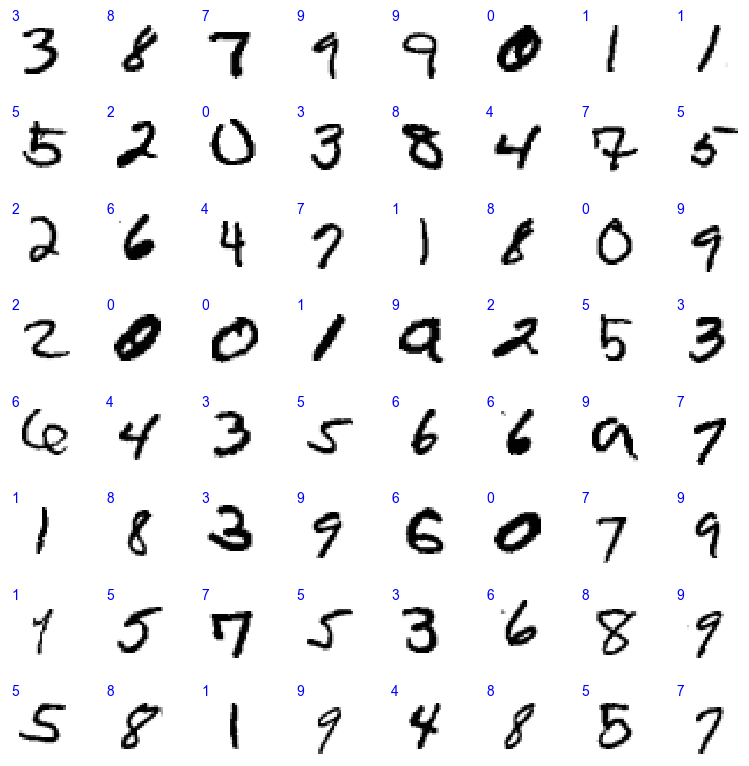

In [204]:
n_rows = 8
n_cols = 8
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.text(.1, .9, y_train[index], color="blue")
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Building the Model

In [205]:
model = Sequential([
Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_1", activation="relu"),
Dropout(rate=0.3),
MaxPool2D(pool_size=(2, 2), name="pool_1"),
Conv2D(filters=64, kernel_size=(5, 5), strides=(1, 1), padding="same", data_format="channels_last", name="conv_2", activation="relu"), 
Dropout(rate=0.3),
MaxPool2D(pool_size=(2, 2), name="pool_2"),
Flatten(),
Dense(units=128, name="fc_1", activation="relu"),
Dropout(rate=0.5),
Dense(units=10, name="fc_2", activation="softmax")
])

In [206]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 14, 14, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_17 (Flatten)            │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_1 (Dense)                    │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc_2 (Dense)                    │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 454,922 (1.74 MB)

 Trainable params: 454,922 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

You can select the appropriate processor below:

In [ ]:
lr_schedule = ExponentialDecay(initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9, staircase=True)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
with tf.device("GPU: 0"):
    history = model.fit(X_train, y_train, epochs=NUM_EPOCHS, validation_data=(X_valid, y_valid), batch_size=BATCH_SIZE)

Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 18s 21ms/step - accuracy: 0.7891 - loss: 0.8442 - val_accuracy: 0.9790 - val_loss: 0.0724
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9630 - loss: 0.1592 - val_accuracy: 0.9819 - val_loss: 0.0649
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9713 - loss: 0.1200 - val_accuracy: 0.9855 - val_loss: 0.0526
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9768 - loss: 0.0991 - val_accuracy: 0.9850 - val_loss: 0.0508
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9805 - loss: 0.0840 - val_accuracy: 0.9882 - val_loss: 0.0488
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9817 - loss: 0.0854 - val_accuracy: 0.9877 - val_loss: 0.0423
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9849 - loss: 0.0627 - val_accuracy: 0.9886 - val_loss: 0.0434
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step - accuracy: 0.9848 - loss: 0.0731 - 

## Model Evaluation

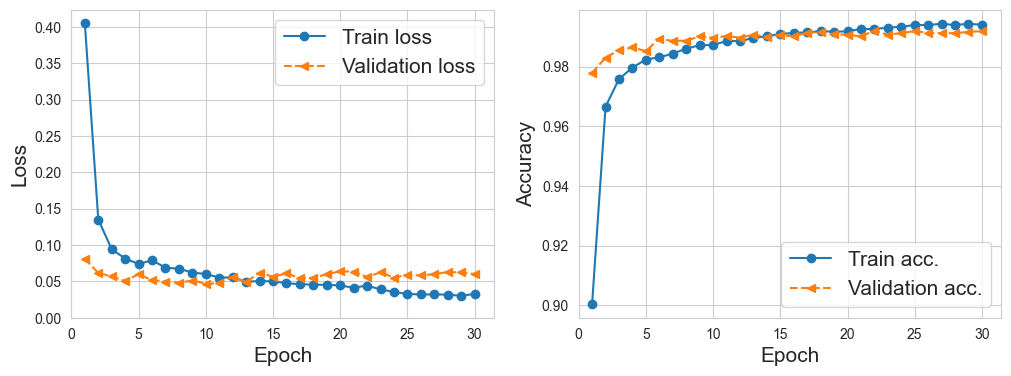

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation loss')
ax.set_xlim(0)
ax.set_xlabel('Epoch', size=15)
ax.set_ylim(0)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlim(0)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_results = model.evaluate(X_test, y_test)
print(f"Test loss: {test_results[0]:.4f}, test acc: {test_results[1]:.4f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9935 - loss: 0.0374
Test loss: 0.0330, test acc: 0.9946
